In [1]:
import uproot
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np
from uproot3_methods import TLorentzVector, TLorentzVectorArray
from coffea.nanoevents.methods import vector
from bbtautau_helpers import reco_nearest_dr_match, eff_hist_lists, fiducial_region_cut
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Fri/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Fri/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/awkward0/persist.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  {"minsize": 8192, "types": [numpy.bool_, numpy.boo

In [2]:
f_path = '../samples/ditau_450166_X1600tohh_bbtautau_lephad.recon.AOD.ntuple.root'
f = uproot.open(f_path)
t = f['mytree']
branches = t.arrays()
print(len(branches))
branches = branches[0:10000]

30000


In [10]:
t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
RunNumber            | uint32_t                 | AsDtype('>u4')
EventNumber          | uint64_t                 | AsDtype('>u8')
PDGTruthMatchType    | uint32_t                 | AsDtype('>u4')
TruthHiggsPt         | float                    | AsDtype('>f4')
TruthHiggsEta        | float                    | AsDtype('>f4')
TruthHiggsPhi        | float                    | AsDtype('>f4')
TruthHiggsE          | float                    | AsDtype('>f4')
TruthHadTauPt        | float                    | AsDtype('>f4')
TruthHadTauEta       | float                    | AsDtype('>f4')
TruthHadTauPhi       | float                    | AsDtype('>f4')
TruthHadTauE         | float                    | AsDtype('>f4')
TruthHadTauPdgId     | int32_t                  | AsDtype('>i4')
TruthHadTauVisPt     | float                    | AsDtype(

In [11]:
print(branches['LeadingLargeRJetPt'])
print(branches['SubleadingLargeRJetPt'])
print(branches['LargeRJetPt'][4])

[715, 821, 786, 702, 689, 738, 709, 889, ... 502, 735, 653, 384, 674, 748, 838, 668]
[491, 362, 270, 173, 546, 704, 618, 243, ... 477, 351, 618, 317, 171, 664, 412, 389]
[689, 546, 120, 38.8, 25.9, 19.1, 18.4]


# Split  into HadEl and HadMu events

In [3]:
nonfid_hadel_branches = branches[branches['PDGTruthMatchType'] == 2]
nonfid_hadmu_branches = branches[branches['PDGTruthMatchType'] == 3]
print('Hadel events: {}'.format(len(nonfid_hadel_branches)))
print('Hadmu events: {}'.format(len(nonfid_hadmu_branches)))

Hadel events: 5035
Hadmu events: 4965


# <ins>Hadel</ins>

# Fiducial Region Definition

In [8]:
hadel_branches = fiducial_region_cut(nonfid_hadel_branches)
print('Total events: ', len(nonfid_hadel_branches))
print('Events in fiducial region: ', len(hadel_branches))

Total events:  5035
Events in fiducial region:  2208


# Create 4-vectors for truth particles

In [10]:
truth_final_lepton_p4 = TLorentzVectorArray.from_ptetaphie(hadel_branches['TruthFinalLeptonPt'],
                                                                 hadel_branches['TruthFinalLeptonEta'],
                                                                 hadel_branches['TruthFinalLeptonPhi'],
                                                                 hadel_branches['TruthFinalLeptonE'])
truth_had_tau_vis_p4 = TLorentzVectorArray.from_ptetaphim(hadel_branches['TruthHadTauVisPt'],
                                                                 hadel_branches['TruthHadTauVisEta'],
                                                                 hadel_branches['TruthHadTauVisPhi'],
                                                                 hadel_branches['TruthHadTauVisM'])
truth_had_tau_p4 = TLorentzVectorArray.from_ptetaphie(hadel_branches['TruthHadTauPt'],
                                                                 hadel_branches['TruthHadTauEta'],
                                                                 hadel_branches['TruthHadTauPhi'],
                                                                 hadel_branches['TruthHadTauE'])
truth_higgs_p4 = TLorentzVectorArray.from_ptetaphie(hadel_branches['TruthHiggsPt'],
                                                                  hadel_branches['TruthHiggsEta'],
                                                                  hadel_branches['TruthHiggsPhi'],
                                                                  hadel_branches['TruthHiggsE'])

# Calculate truth quantities

In [12]:
truth_vis_dr = truth_had_tau_vis_p4.delta_r(truth_final_lepton_p4)
truth_ditau_vis_p4 = truth_had_tau_vis_p4 + truth_final_lepton_p4
truth_ditau_p4 = truth_had_tau_p4 + truth_final_lepton_p4

# Truth plots

### Electrons

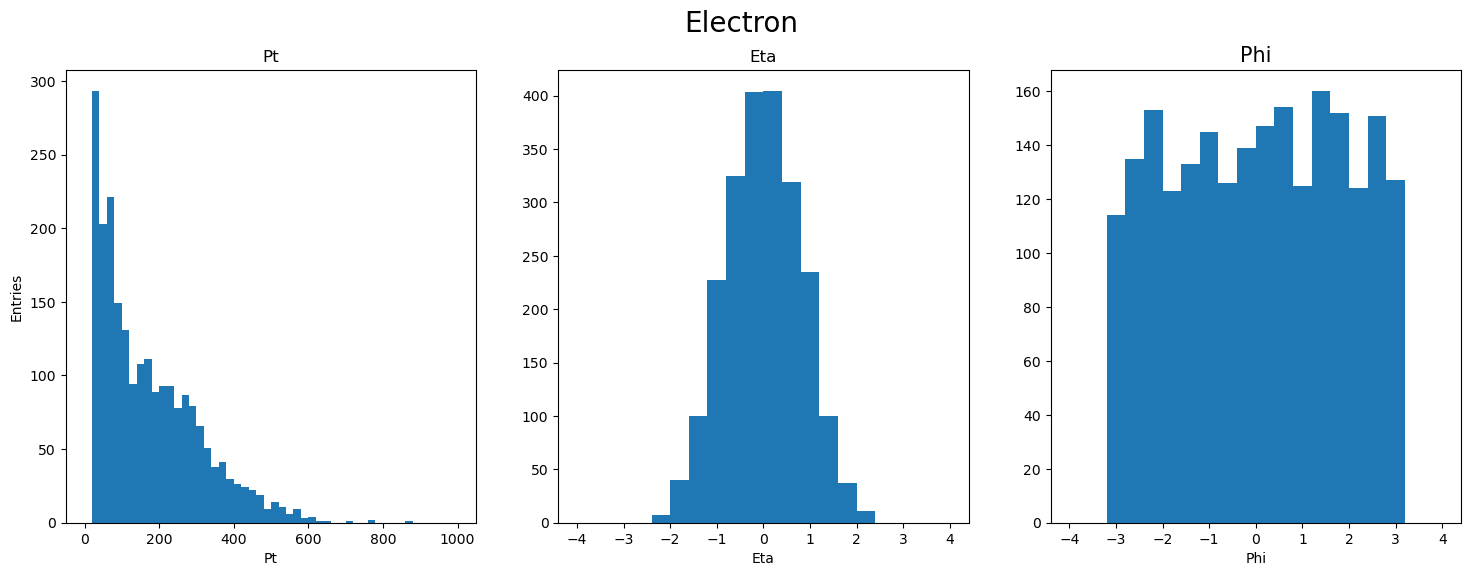

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.hist(truth_final_lepton_p4.pt, bins=50, range=(0, 1000))
ax1.set_xlabel('Pt')
ax1.set_ylabel('Entries')
ax1.set_title('Pt')
ax2.hist(truth_final_lepton_p4.eta, bins=20, range=(-4, 4))
ax2.set_xlabel('Eta')
ax2.set_title('Eta')
ax3.hist(truth_final_lepton_p4.phi, bins=20, range=(-4, 4))
ax3.set_xlabel('Phi')
ax3.set_title('Phi', size=15)
fig.suptitle('Electron', size=20)
plt.show()

### Taus

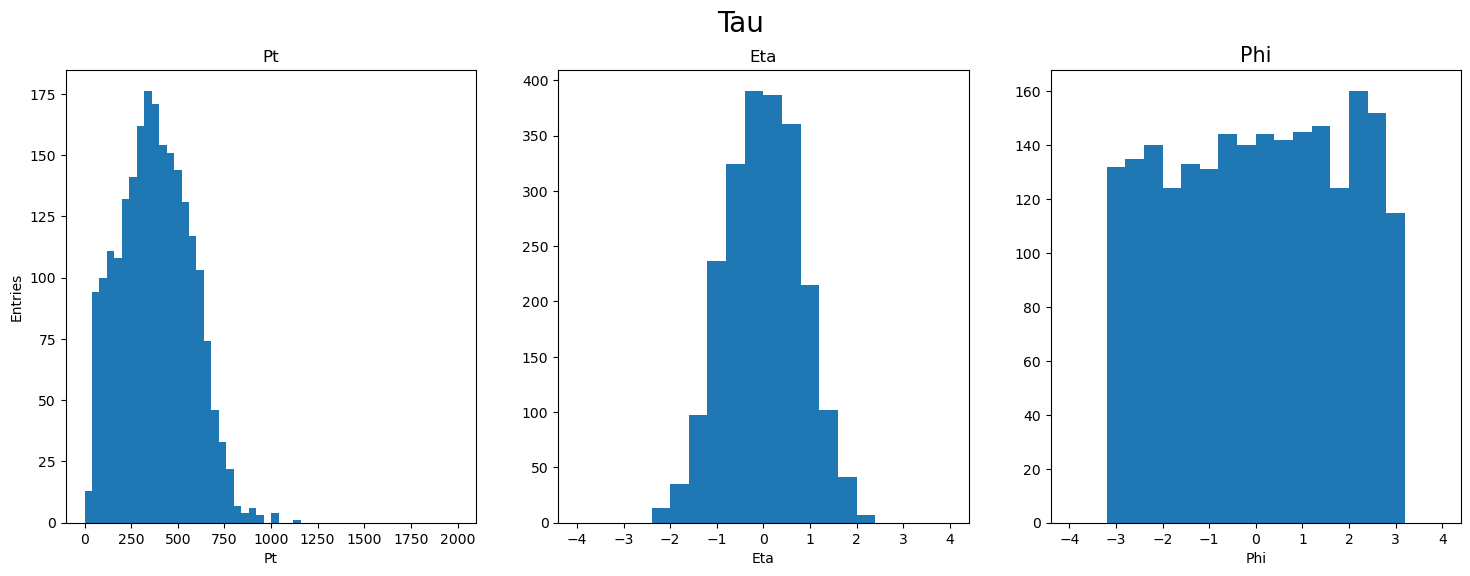

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.hist(truth_had_tau_p4.pt, bins=50, range=(0, 2000))
ax1.set_xlabel('Pt')
ax1.set_ylabel('Entries')
ax1.set_title('Pt')
ax2.hist(truth_had_tau_p4.eta, bins=20, range=(-4, 4))
ax2.set_xlabel('Eta')
ax2.set_title('Eta')
ax3.hist(truth_had_tau_p4.phi, bins=20, range=(-4, 4))
ax3.set_xlabel('Phi')
ax3.set_title('Phi', size=15)
fig.suptitle('Tau', size=20)
plt.show()

### Visible Taus

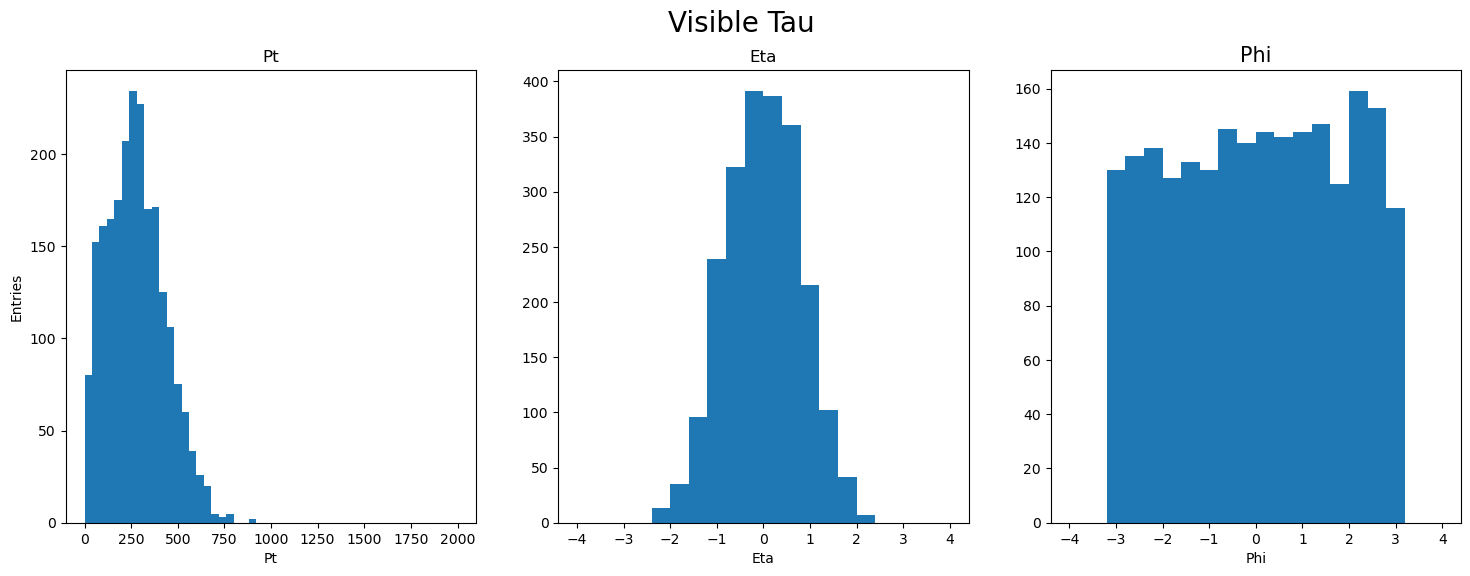

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.hist(truth_had_tau_vis_p4.pt, bins=50, range=(0, 2000))
ax1.set_xlabel('Pt')
ax1.set_ylabel('Entries')
ax1.set_title('Pt')
ax2.hist(truth_had_tau_vis_p4.eta, bins=20, range=(-4, 4))
ax2.set_xlabel('Eta')
ax2.set_title('Eta')
ax3.hist(truth_had_tau_vis_p4.phi, bins=20, range=(-4, 4))
ax3.set_xlabel('Phi')
ax3.set_title('Phi', size=15)
fig.suptitle('Visible Tau', size=20)
plt.show()

### Higgs

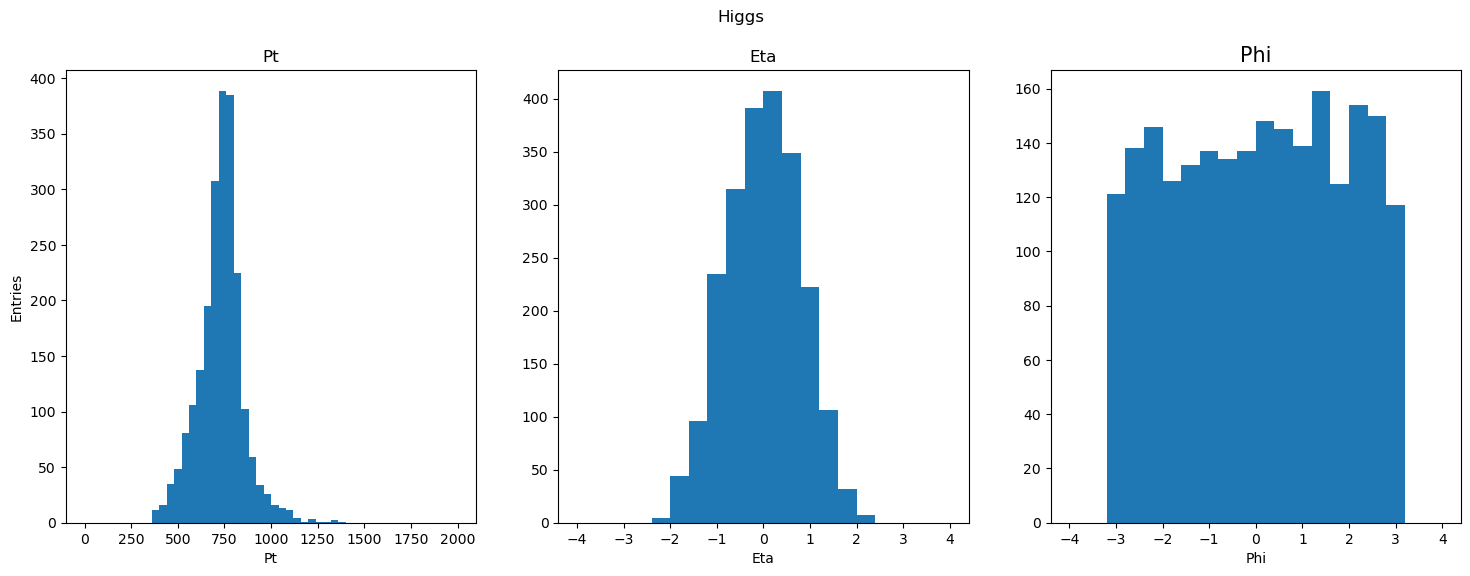

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.hist(truth_higgs_p4.pt, bins=50, range=(0, 2000))
ax1.set_xlabel('Pt')
ax1.set_ylabel('Entries')
ax1.set_title('Pt')
ax2.hist(truth_higgs_p4.eta, bins=20, range=(-4, 4))
ax2.set_xlabel('Eta')
ax2.set_title('Eta')
ax3.hist(truth_higgs_p4.phi, bins=20, range=(-4, 4))
ax3.set_xlabel('Phi')
ax3.set_title('Phi', size=15)
fig.suptitle('Higgs')
plt.show()

# Create 4-vectors for reco particles

In [13]:
reco_tau_p4 = []
loose_reco_tau_p4 = []
medium_reco_tau_p4 = []
tight_reco_tau_p4 = []
for i in range(len(hadel_branches['TauPt'])):
    #if i%2000 == 0:
    #    print(i)
    event_taus = TLorentzVectorArray.from_ptetaphie(hadel_branches['TauPt'][i], hadel_branches['TauEta'][i], hadel_branches['TauPhi'][i], hadel_branches['TauE'][i])
    loose_event_taus = TLorentzVectorArray.from_ptetaphie(hadel_branches['TauLoosePt'][i], hadel_branches['TauLooseEta'][i], hadel_branches['TauLoosePhi'][i], hadel_branches['TauLooseE'][i])
    medium_event_taus = TLorentzVectorArray.from_ptetaphie(hadel_branches['TauMediumPt'][i], hadel_branches['TauMediumEta'][i], hadel_branches['TauMediumPhi'][i], hadel_branches['TauMediumE'][i])
    tight_event_taus = TLorentzVectorArray.from_ptetaphie(hadel_branches['TauTightPt'][i], hadel_branches['TauTightEta'][i], hadel_branches['TauTightPhi'][i], hadel_branches['TauTightE'][i])
    reco_tau_p4.append(event_taus)
    loose_reco_tau_p4.append(loose_event_taus)
    medium_reco_tau_p4.append(medium_event_taus)
    tight_reco_tau_p4.append(tight_event_taus)

reco_ele_p4 = []
loose_reco_ele_p4 = []
medium_reco_ele_p4 = []
tight_reco_ele_p4 = []
for i in range(len(hadel_branches['ElePt'])):
    #if i%2000 == 0:
    #    print(i)
    event_eles = TLorentzVectorArray.from_ptetaphie(hadel_branches['ElePt'][i], hadel_branches['EleEta'][i], hadel_branches['ElePhi'][i], hadel_branches['EleE'][i])
    loose_event_eles = TLorentzVectorArray.from_ptetaphie(hadel_branches['EleLoosePt'][i], hadel_branches['EleLooseEta'][i], hadel_branches['EleLoosePhi'][i], hadel_branches['EleLooseE'][i])
    medium_event_eles = TLorentzVectorArray.from_ptetaphie(hadel_branches['EleMediumPt'][i], hadel_branches['EleMediumEta'][i], hadel_branches['EleMediumPhi'][i], hadel_branches['EleMediumE'][i])
    tight_event_eles = TLorentzVectorArray.from_ptetaphie(hadel_branches['EleTightPt'][i], hadel_branches['EleTightEta'][i], hadel_branches['EleTightPhi'][i], hadel_branches['EleTightE'][i])
    reco_ele_p4.append(event_eles)
    loose_reco_ele_p4.append(loose_event_eles)
    medium_reco_ele_p4.append(medium_event_eles)
    tight_reco_ele_p4.append(tight_event_eles)

#### Create mask for events with truth-matched HadEl ditau

In [14]:
tm_hadel_ditau_pts = []
tm_hadel_ditau_indices = []
for i in range(len(hadel_branches['HadElDiTauPt'])):
    # Create hadel TM mask for all hadel ditaus in event
    event_hadel_tm_mask = hadel_branches['HadElDiTauTruthMatchType'][i] == 2
    # Get Pt of all TM hadel ditaus
    tm_pts = hadel_branches['HadElDiTauPt'][i][event_hadel_tm_mask]
    
    # If multiple matches found, choose leading ditau, if none fill -1
    if len(tm_pts) > 0:
        pt = max(tm_pts)
        pt_ind = np.where(hadel_branches['HadElDiTauPt'][i] == pt)[0][0]
    else:
        pt = -1
        pt_ind = -1
    tm_hadel_ditau_indices.append(pt_ind)
    tm_hadel_ditau_pts.append(pt)
    
# Holds leading TM hadel ditau pt
tm_hadel_ditau_pts = np.array(tm_hadel_ditau_pts)
# Holds index of leading TM hadel
tm_hadel_ditau_indices = np.array(tm_hadel_ditau_indices)
# Mask for whether TM hadel ditau was found for this event
tm_hadel_event_mask = np.array(tm_hadel_ditau_pts > 0)

print('Events before: ',len(tm_hadel_event_mask))
print('Events after: ',sum(tm_hadel_event_mask))

Events before:  2208
Events after:  1945


# Calculate some reco values

In [15]:
nearest_reco_taus = reco_nearest_dr_match(truth_had_tau_vis_p4, reco_tau_p4)
nearest_reco_tau_drs = truth_had_tau_vis_p4.delta_r(nearest_reco_taus)
nearest_loose_reco_taus = reco_nearest_dr_match(truth_had_tau_vis_p4, loose_reco_tau_p4)
nearest_loose_tau_drs = truth_had_tau_vis_p4.delta_r(nearest_loose_reco_taus)

nearest_reco_eles = reco_nearest_dr_match(truth_final_lepton_p4, reco_ele_p4)
nearest_reco_ele_drs = truth_final_lepton_p4.delta_r(nearest_reco_eles)
nearest_loose_reco_eles = reco_nearest_dr_match(truth_final_lepton_p4, loose_reco_ele_p4)
nearest_loose_ele_drs = truth_final_lepton_p4.delta_r(nearest_loose_reco_eles)

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Fri/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/awkward0/array/base.py:378: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return isinstance(x, (numbers.Integral, cls.numpy.integer)) and not isinstance(x, (bool, cls.numpy.bool_, cls.numpy.bool))


### Matched tau masks - dR < 0.2

In [16]:
matched_tau_mask = nearest_reco_tau_drs < 0.2
matched_truth_taus = truth_had_tau_vis_p4[matched_tau_mask]

matched_loose_tau_mask = nearest_loose_tau_drs < 0.2
matched_loose_truth_taus = truth_had_tau_vis_p4[matched_loose_tau_mask]

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Fri/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/awkward0/array/base.py:622: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(where, (cls.numpy.ndarray, AwkwardArray)) and issubclass(where.dtype.type, (numpy.str, numpy.str_)):
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Fri/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/awkward0/array/base.py:624: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://nump

### Matched electron masks - dR < 0.2

In [17]:
matched_ele_mask = nearest_reco_ele_drs < 0.2
matched_truth_eles = truth_final_lepton_p4[matched_ele_mask]

matched_loose_ele_mask = nearest_loose_ele_drs < 0.2
matched_loose_truth_eles = truth_final_lepton_p4[matched_loose_ele_mask]

# Tau Reco Efficiency - matched if dR < 0.2

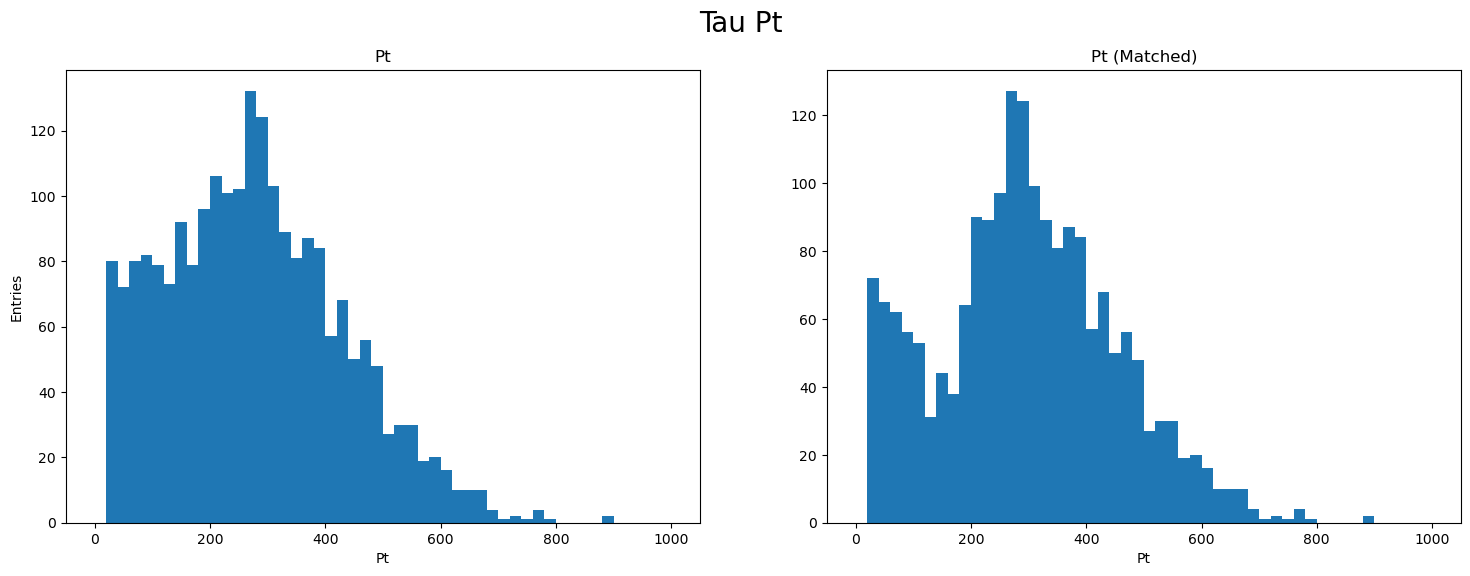

/eos/home-i00/n/nicholas/SWAN_projects/DiTauReco/scripts/bbtautau_helpers.py:304: RuntimeWarning: invalid value encountered in true_divide
  eff_hist = np.divide(num_hist, denom_hist)


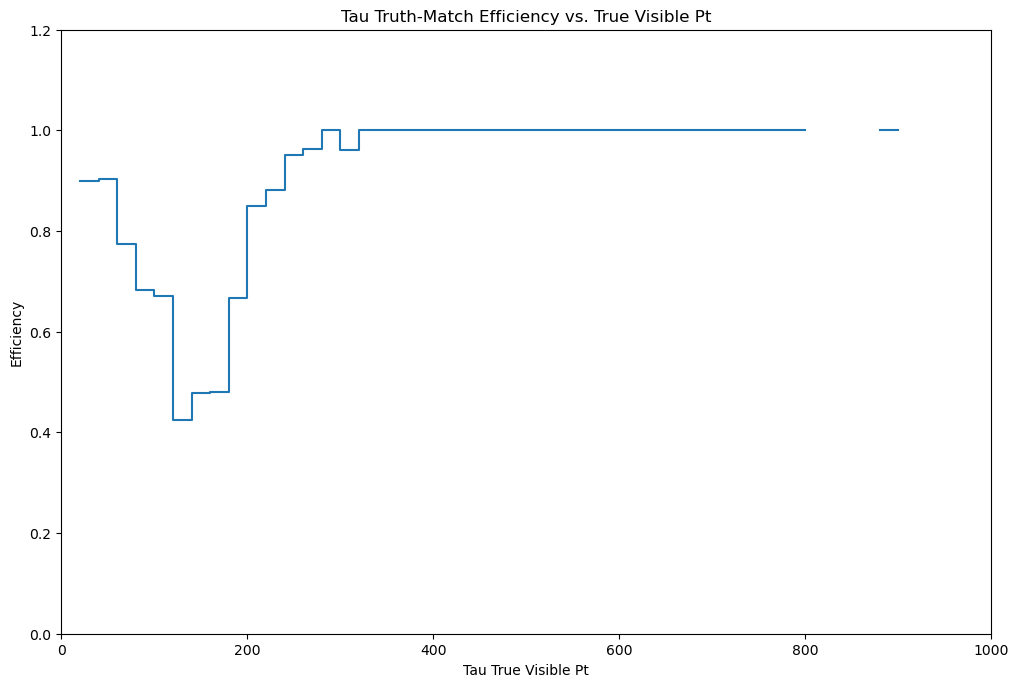

In [39]:
bin_number = 50
low_range = 0
high_range = 1000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.hist(truth_had_tau_vis_p4.pt, bins=bin_number, range=(low_range, high_range))
ax1.set_xlabel('Pt')
ax1.set_ylabel('Entries')
ax1.set_title('Pt')
ax2.hist(matched_truth_taus.pt, bins=bin_number, range=(low_range, high_range))
ax2.set_xlabel('Pt')
ax2.set_title('Pt (Matched)')
fig.suptitle('Tau Pt', size=20)
plt.show()

plot_x, plot_y = eff_hist_lists(matched_truth_taus.pt, truth_had_tau_vis_p4.pt, low_range, high_range, bin_number)

plt.plot(plot_x, plot_y, drawstyle='steps')
plt.ylim(0, 1.2)
plt.xlim(low_range, high_range)
plt.xlabel('Tau True Visible Pt')
plt.ylabel('Efficiency')
plt.title('Tau Truth-Match Efficiency vs. True Visible Pt')
plt.show()

# Electron Reco Efficiency - matched if dR < 0.2

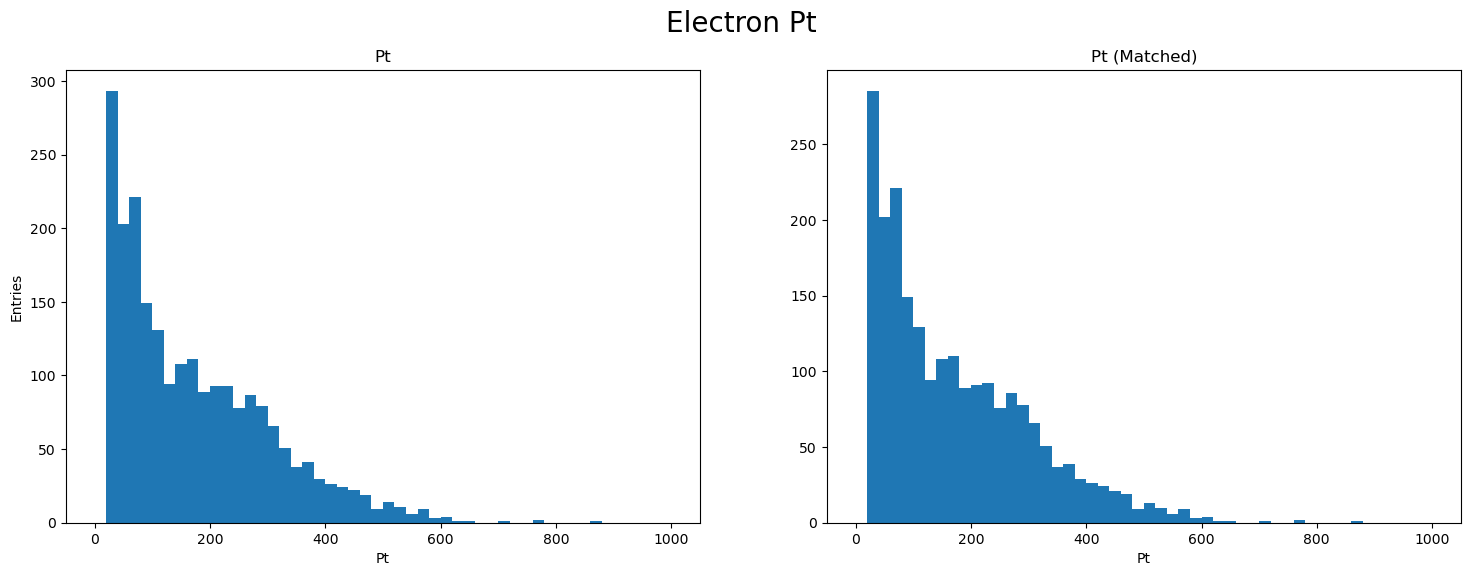

/eos/home-i00/n/nicholas/SWAN_projects/DiTauReco/scripts/bbtautau_helpers.py:304: RuntimeWarning: invalid value encountered in true_divide
  eff_hist = np.divide(num_hist, denom_hist)


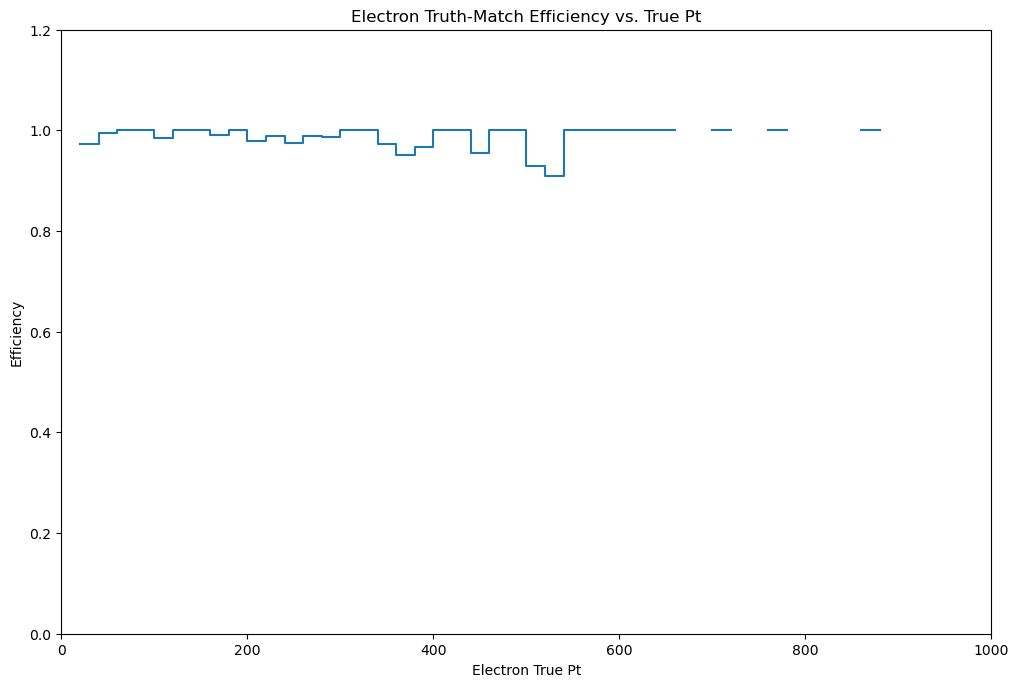

In [41]:
bin_number = 50
low_range = 0
high_range = 1000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.hist(truth_final_lepton_p4.pt, bins=bin_number, range=(low_range, high_range))
ax1.set_xlabel('Pt')
ax1.set_ylabel('Entries')
ax1.set_title('Pt')
ax2.hist(matched_truth_eles.pt, bins=bin_number, range=(low_range, high_range))
ax2.set_xlabel('Pt')
ax2.set_title('Pt (Matched)')
fig.suptitle('Electron Pt', size=20)
plt.show()

plot_x, plot_y = eff_hist_lists(matched_truth_eles.pt, truth_final_lepton_p4.pt, low_range, high_range, bin_number)

plt.plot(plot_x, plot_y, drawstyle='steps')
plt.ylim(0, 1.2)
plt.xlim(low_range, high_range)
plt.xlabel('Electron True Pt')
plt.ylabel('Efficiency')
plt.title('Electron Truth-Match Efficiency vs. True Pt')
plt.show()

# Tau + Electron Separate Reco Efficiency

In [18]:
both_matched_mask = matched_tau_mask & matched_ele_mask
both_matched_loose_tau_mask = matched_loose_tau_mask & matched_ele_mask
both_matched_loose_ele_mask = matched_tau_mask & matched_loose_ele_mask
both_matched_both_loose_mask = matched_loose_tau_mask & matched_loose_ele_mask

matched_truth_ditau_vis_p4 = truth_ditau_vis_p4[both_matched_mask]

### True Visible dR

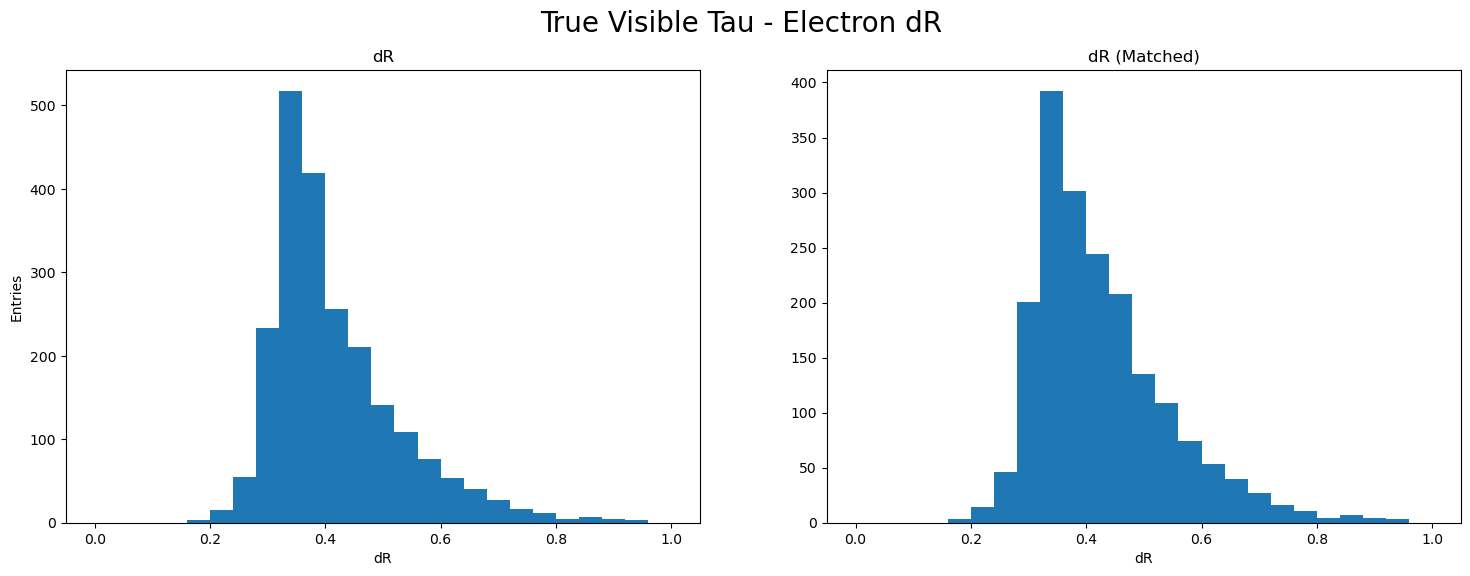

/eos/home-i00/n/nicholas/SWAN_projects/DiTauReco/scripts/bbtautau_helpers.py:304: RuntimeWarning: invalid value encountered in true_divide
  eff_hist = np.divide(num_hist, denom_hist)


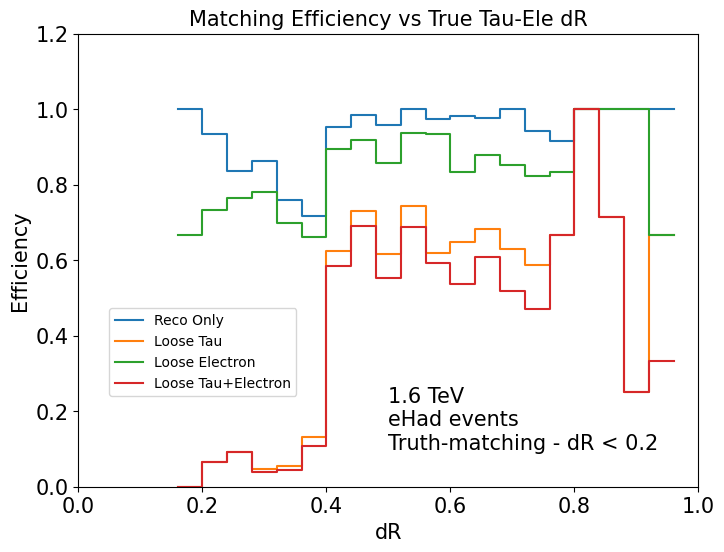

In [24]:
bin_number = 25
low_range = 0
high_range = 1

matched_truth_vis_drs = truth_vis_dr[both_matched_mask]
loose_tau_matched_truth_vis_drs = truth_vis_dr[both_matched_loose_tau_mask]
loose_ele_matched_truth_vis_drs = truth_vis_dr[both_matched_loose_ele_mask]
loose_both_matched_truth_vis_drs = truth_vis_dr[both_matched_both_loose_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.hist(truth_vis_dr, bins=bin_number, range=(low_range, high_range))
ax1.set_xlabel('dR')
ax1.set_ylabel('Entries')
ax1.set_title('dR')
ax2.hist(matched_truth_vis_drs, bins=bin_number, range=(low_range, high_range))
ax2.set_xlabel('dR')
ax2.set_title('dR (Matched)')
fig.suptitle('True Visible Tau - Electron dR', size=20)
plt.show()

reco_plot_x, reco_plot_y = eff_hist_lists(matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)
loose_tau_plot_x, loose_tau_plot_y = eff_hist_lists(loose_tau_matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)
loose_ele_plot_x, loose_ele_plot_y = eff_hist_lists(loose_ele_matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)
loose_both_plot_x, loose_both_plot_y = eff_hist_lists(loose_both_matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)

plt.figure(figsize=(8,6))
plt.plot(reco_plot_x, reco_plot_y, drawstyle='steps', label='Reco Only')
plt.ylim(0, 1.2)
plt.xlim(low_range, high_range)
plt.xlabel('dR', size=15)
plt.xticks(size=15)
plt.ylabel('Efficiency', size=15)
plt.yticks(size=15)
plt.title('Matching Efficiency vs True Tau-Ele dR', size=15)
plt.plot(loose_tau_plot_x, loose_tau_plot_y, drawstyle='steps', label='Loose Tau')
plt.plot(loose_ele_plot_x, loose_ele_plot_y, drawstyle='steps', label='Loose Electron')
plt.plot(loose_both_plot_x, loose_both_plot_y, drawstyle='steps', label='Loose Tau+Electron')
plt.text(0.5, 0.1, '1.6 TeV\neHad events\nTruth-matching - dR < 0.2', size=15)
plt.legend(loc=[0.05, 0.2])
plt.show()

In [44]:
print('Reco %: ',len(matched_truth_vis_drs)/len(truth_vis_dr))
print('Loose electron %: ',len(loose_ele_matched_truth_vis_drs)/len(truth_vis_dr))
print('Loose tau %: ',len(loose_tau_matched_truth_vis_drs)/len(truth_vis_dr))
print('Loose both %: ',len(loose_both_matched_truth_vis_drs)/len(truth_vis_dr))

Reco %:  0.8586956521739131
Loose electron %:  0.7884963768115942
Loose tau %:  0.3365036231884058
Loose both %:  0.3061594202898551


### True Visible Pt

In [ ]:
bin_number = 50
low_range = 0
high_range = 1200

matched_truth_ditau_vis_p4 = truth_ditau_vis_p4[both_matched_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.hist(truth_ditau_vis_p4.pt / 1000., bins=bin_number, range=(low_range, high_range))
ax1.set_xlabel('Pt')
ax1.set_ylabel('Entries')
ax1.set_title('Pt')
ax2.hist(matched_truth_ditau_vis_p4.pt / 1000., bins=bin_number, range=(low_range, high_range))
ax2.set_xlabel('Pt')
ax2.set_title('Pt (Matched)')
fig.suptitle('True Visible Tau - Electron Pt', size=20)
plt.show()

plot_x, plot_y = eff_hist_lists(matched_truth_ditau_vis_p4.pt / 1000., truth_ditau_vis_p4.pt / 1000., low_range, high_range, bin_number)

plt.plot(plot_x, plot_y, drawstyle='steps')
plt.ylim(0, 1.2)
plt.xlim(low_range, high_range)
plt.xlabel('Pt')
plt.ylabel('Efficiency')
plt.title('True Visible Tau - Electron Pt')
plt.show()

# Tau + Muon Separate Reco Efficiency

# DiTau Efficiency

### True Higgs Pt

In [ ]:
bin_number = 50
low_range = 0
high_range = 2000

matched_truth_higgs_p4 = truth_higgs_p4[tm_hadel_event_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.hist(truth_higgs_p4.pt / 1000., bins=bin_number, range=(low_range, high_range))
ax1.set_xlabel('Pt')
ax1.set_ylabel('Entries')
ax1.set_title('Pt')
ax2.hist(matched_truth_higgs_p4.pt / 1000., bins=bin_number, range=(low_range, high_range))
ax2.set_xlabel('Pt')
ax2.set_title('Pt (Matched)')
fig.suptitle('True Higgs Pt', size=20)
plt.show()

plot_x, plot_y = eff_hist_lists(matched_truth_higgs_p4.pt / 1000., truth_higgs_p4.pt / 1000., low_range, high_range, bin_number)

plt.plot(plot_x, plot_y, drawstyle='steps')
plt.ylim(0, 1.2)
plt.xlim(low_range, high_range)
plt.xlabel('Pt')
plt.ylabel('Efficiency')
plt.title('True Higgs Pt')
plt.show()

### True Visible dR

In [ ]:
bin_number = 50
low_range = 0
high_range = 1

matched_truth_vis_drs = truth_vis_dr[tm_hadel_event_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.hist(truth_vis_dr, bins=bin_number, range=(low_range, high_range))
ax1.set_xlabel('dR')
ax1.set_ylabel('Entries')
ax1.set_title('dR')
ax2.hist(matched_truth_vis_drs, bins=bin_number, range=(low_range, high_range))
ax2.set_xlabel('dR')
ax2.set_title('dR (Matched)')
fig.suptitle('True Visible Tau - Electron dR', size=20)
plt.show()

plot_x, plot_y = eff_hist_lists(matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)

plt.plot(plot_x, plot_y, drawstyle='steps')
plt.ylim(0, 1.2)
plt.xlim(low_range, high_range)
plt.xlabel('dR')
plt.ylabel('Efficiency')
plt.title('True Visible Tau - Electron dR')
plt.show()

# DiTau BDT Identification

### All Reconstructed DiTaus

In [ ]:
plt.hist(ak.flatten(hadel_branches['HadElDiTauBDTScore']))
plt.xlabel('BDT Score')
plt.ylabel('Entries')
plt.show()

In [ ]:
tm_hadel_all_bdt_scores = hadel_branches['HadElDiTauBDTScore'][tm_hadel_event_mask]
tm_hadel_bdt_scores = np.array([scores[i] for i, scores in zip(tm_hadel_ditau_indices[tm_hadel_event_mask], tm_hadel_all_bdt_scores)])

In [ ]:
print(len(tm_hadel_all_bdt_scores))
print(len(tm_hadel_event_mask))
print(len(tm_hadel_bdt_scores))

### Truth-Matched Reconstructed DiTaus

In [ ]:
plt.hist(tm_hadel_bdt_scores)
plt.show()

In [ ]:
plt.hist(ak.flatten(hadel_branches['HadElDiTauFlatBDTScore']))
plt.xlabel('BDT Score')
plt.ylabel('Entries')
plt.show()

In [ ]:
tm_hadel_all_flat_bdt_scores = hadel_branches['HadElDiTauFlatBDTScore'][tm_hadel_event_mask]
tm_hadel_flat_bdt_scores = [scores[i] for i, scores in zip(tm_hadel_ditau_indices[tm_hadel_event_mask], tm_hadel_all_flat_bdt_scores)]

In [ ]:
plt.hist(tm_hadel_flat_bdt_scores)
plt.show()

In [ ]:
tm_hadel_sorted_bdt_scores = np.sort(tm_hadel_bdt_scores)

In [ ]:
num_bdt_scores = len(tm_hadel_sorted_bdt_scores)

# t = Tight, m = Medium, l = Loose, vl = Very Loose
t_bdt_wp_ind = int(num_bdt_scores * 0.5)
t_bdt_wp = tm_hadel_sorted_bdt_scores[t_bdt_wp_ind]
m_bdt_wp_ind = int(num_bdt_scores * 0.35)
m_bdt_wp = tm_hadel_sorted_bdt_scores[m_bdt_wp_ind]
l_bdt_wp_ind = int(num_bdt_scores * 0.2)
l_bdt_wp = tm_hadel_sorted_bdt_scores[l_bdt_wp_ind]
vl_bdt_wp_ind = int(num_bdt_scores * 0.05)
vl_bdt_wp = tm_hadel_sorted_bdt_scores[vl_bdt_wp_ind]

In [ ]:
tm_hadel_bdt_t_mask = tm_hadel_bdt_scores > t_bdt_wp
tm_hadel_bdt_m_mask = tm_hadel_bdt_scores > m_bdt_wp
tm_hadel_bdt_l_mask = tm_hadel_bdt_scores > l_bdt_wp
tm_hadel_bdt_vl_mask = tm_hadel_bdt_scores > vl_bdt_wp

In [ ]:
bin_number = 50
low_range = 0
high_range = 1
bin_step = high_range / bin_number

matched_truth_vis_drs = truth_vis_dr[tm_hadel_event_mask]
t_matched_truth_vis_drs = matched_truth_vis_drs[tm_hadel_bdt_t_mask]
m_matched_truth_vis_drs = matched_truth_vis_drs[tm_hadel_bdt_m_mask]
l_matched_truth_vis_drs = matched_truth_vis_drs[tm_hadel_bdt_l_mask]
vl_matched_truth_vis_drs = matched_truth_vis_drs[tm_hadel_bdt_vl_mask]

plot_x, plot_y = eff_hist_lists(matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)
vl_plot_x, vl_plot_y = eff_hist_lists(vl_matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)
l_plot_x, l_plot_y = eff_hist_lists(l_matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)
m_plot_x, m_plot_y = eff_hist_lists(m_matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)
t_plot_x, t_plot_y = eff_hist_lists(t_matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)

plt.figure(figsize=(8,6))
plt.plot(plot_x, plot_y, drawstyle='steps', label='No cut')
plt.ylim(0, 1.5)
plt.xlim(low_range, high_range)
plt.xlabel('dR')
plt.ylabel('Efficiency')
plt.title('True Visible Tau - Electron dR')
plt.plot(vl_plot_x, vl_plot_y, drawstyle='steps', label='Very Loose - 95%')
plt.plot(l_plot_x, l_plot_y, drawstyle='steps', label='Loose - 80%')
plt.plot(m_plot_x, m_plot_y, drawstyle='steps', label='Medium - 65%')
plt.plot(t_plot_x, t_plot_y, drawstyle='steps', label='Tight - 50%')
plt.legend()
plt.show()

In [ ]:
print('Reco %: ',len(matched_truth_vis_drs)/len(truth_vis_dr))
print('Very Loose %: ',len(vl_matched_truth_vis_drs)/len(truth_vis_dr))
print('Loose %: ',len(l_matched_truth_vis_drs)/len(truth_vis_dr))
print('Medium %: ',len(m_matched_truth_vis_drs)/len(truth_vis_dr))
print('Tight %: ',len(t_matched_truth_vis_drs)/len(truth_vis_dr))

# <ins>Hadmu</ins>

# Fiducial Region Definition

In [27]:
hadmu_branches = fiducial_region_cut(nonfid_hadmu_branches)
print('Total events: ', len(nonfid_hadmu_branches))
print('Events in fiducial region: ', len(hadmu_branches))

Total events:  4965
Events in fiducial region:  2150


# Create 4-vectors for truth particles

In [43]:
truth_final_lepton_p4 = TLorentzVectorArray.from_ptetaphie(hadmu_branches['TruthFinalLeptonPt'],
                                                                 hadmu_branches['TruthFinalLeptonEta'],
                                                                 hadmu_branches['TruthFinalLeptonPhi'],
                                                                 hadmu_branches['TruthFinalLeptonE'])
truth_had_tau_vis_p4 = TLorentzVectorArray.from_ptetaphim(hadmu_branches['TruthHadTauVisPt'],
                                                                 hadmu_branches['TruthHadTauVisEta'],
                                                                 hadmu_branches['TruthHadTauVisPhi'],
                                                                 hadmu_branches['TruthHadTauVisM'])
truth_had_tau_p4 = TLorentzVectorArray.from_ptetaphie(hadmu_branches['TruthHadTauPt'],
                                                                 hadmu_branches['TruthHadTauEta'],
                                                                 hadmu_branches['TruthHadTauPhi'],
                                                                 hadmu_branches['TruthHadTauE'])
truth_higgs_p4 = TLorentzVectorArray.from_ptetaphie(hadmu_branches['TruthHiggsPt'],
                                                                  hadmu_branches['TruthHiggsEta'],
                                                                  hadmu_branches['TruthHiggsPhi'],
                                                                  hadmu_branches['TruthHiggsE'])

In [59]:
truth_vis_dr = truth_had_tau_vis_p4.delta_r(truth_final_lepton_p4)
truth_ditau_vis_p4 = truth_had_tau_vis_p4 + truth_final_lepton_p4
truth_ditau_p4 = truth_had_tau_p4 + truth_final_lepton_p4

# Create 4-vectors for reco particles

In [45]:
reco_tau_p4 = []
loose_reco_tau_p4 = []
medium_reco_tau_p4 = []
tight_reco_tau_p4 = []
for i in range(len(hadmu_branches['TauPt'])):
    #if i%2000 == 0:
    #    print(i)
    event_taus = TLorentzVectorArray.from_ptetaphie(hadmu_branches['TauPt'][i], hadmu_branches['TauEta'][i], hadmu_branches['TauPhi'][i], hadmu_branches['TauE'][i])
    loose_event_taus = TLorentzVectorArray.from_ptetaphie(hadmu_branches['TauLoosePt'][i], hadmu_branches['TauLooseEta'][i], hadmu_branches['TauLoosePhi'][i], hadmu_branches['TauLooseE'][i])
    medium_event_taus = TLorentzVectorArray.from_ptetaphie(hadmu_branches['TauMediumPt'][i], hadmu_branches['TauMediumEta'][i], hadmu_branches['TauMediumPhi'][i], hadmu_branches['TauMediumE'][i])
    tight_event_taus = TLorentzVectorArray.from_ptetaphie(hadmu_branches['TauTightPt'][i], hadmu_branches['TauTightEta'][i], hadmu_branches['TauTightPhi'][i], hadmu_branches['TauTightE'][i])
    reco_tau_p4.append(event_taus)
    loose_reco_tau_p4.append(loose_event_taus)
    medium_reco_tau_p4.append(medium_event_taus)
    tight_reco_tau_p4.append(tight_event_taus)

reco_mu_p4 = []
loose_reco_mu_p4 = []
medium_reco_mu_p4 = []
tight_reco_mu_p4 = []
for i in range(len(hadmu_branches['MuPt'])):
    #if i%2000 == 0:
    #    print(i)
    event_mus = TLorentzVectorArray.from_ptetaphie(hadmu_branches['MuPt'][i], hadmu_branches['MuEta'][i], hadmu_branches['MuPhi'][i], hadmu_branches['MuE'][i])
    loose_event_mus = TLorentzVectorArray.from_ptetaphie(hadmu_branches['MuLoosePt'][i], hadmu_branches['MuLooseEta'][i], hadmu_branches['MuLoosePhi'][i], hadmu_branches['MuLooseE'][i])
    medium_event_mus = TLorentzVectorArray.from_ptetaphie(hadmu_branches['MuMediumPt'][i], hadmu_branches['MuMediumEta'][i], hadmu_branches['MuMediumPhi'][i], hadmu_branches['MuMediumE'][i])
    tight_event_mus = TLorentzVectorArray.from_ptetaphie(hadmu_branches['MuTightPt'][i], hadmu_branches['MuTightEta'][i], hadmu_branches['MuTightPhi'][i], hadmu_branches['MuTightE'][i])
    reco_mu_p4.append(event_mus)
    loose_reco_mu_p4.append(loose_event_mus)
    medium_reco_mu_p4.append(medium_event_mus)
    tight_reco_mu_p4.append(tight_event_mus)

#### Create mask for events with truth-matched HadMu ditau

In [46]:
tm_hadmu_ditau_pts = []
tm_hadmu_ditau_indices = []
for i in range(len(hadmu_branches['HadMuDiTauPt'])):
    # Create hadmu TM mask for all hadmu ditaus in event
    event_hadmu_tm_mask = hadmu_branches['HadMuDiTauTruthMatchType'][i] == 3
    # Get Pt of all TM hadmu ditaus
    tm_pts = hadmu_branches['HadMuDiTauPt'][i][event_hadmu_tm_mask]
    
    # If multiple matches found, choose leading ditau, if none fill -1
    if len(tm_pts) > 0:
        pt = max(tm_pts)
        pt_ind = np.where(hadmu_branches['HadMuDiTauPt'][i] == pt)[0][0]
    else:
        pt = -1
        pt_ind = -1
    tm_hadmu_ditau_indices.append(pt_ind)
    tm_hadmu_ditau_pts.append(pt)
    
# Holds leading TM hadmu ditau pt
tm_hadmu_ditau_pts = np.array(tm_hadmu_ditau_pts)
# Holds index of leading TM hadmu
tm_hadmu_ditau_indices = np.array(tm_hadmu_ditau_indices)
# Mask for whether TM hadmu ditau was found for this event
tm_hadmu_event_mask = np.array(tm_hadmu_ditau_pts > 0)

print('Events before: ',len(tm_hadmu_event_mask))
print('Events after: ',sum(tm_hadmu_event_mask))

Events before:  2150
Events after:  2030


# Calculate some reco values

In [54]:
nearest_reco_taus = reco_nearest_dr_match(truth_had_tau_vis_p4, reco_tau_p4)
nearest_reco_tau_drs = truth_had_tau_vis_p4.delta_r(nearest_reco_taus)

nearest_loose_reco_taus = reco_nearest_dr_match(truth_had_tau_vis_p4, loose_reco_tau_p4)
nearest_loose_tau_drs = truth_had_tau_vis_p4.delta_r(nearest_loose_reco_taus)

nearest_reco_mus = reco_nearest_dr_match(truth_final_lepton_p4, reco_mu_p4)
nearest_reco_mu_drs = truth_final_lepton_p4.delta_r(nearest_reco_mus)
nearest_loose_reco_mus = reco_nearest_dr_match(truth_final_lepton_p4, loose_reco_mu_p4)
nearest_loose_mu_drs = truth_final_lepton_p4.delta_r(nearest_loose_reco_mus)

### Matched tau masks - dR < 0.2

In [62]:
matched_tau_mask = nearest_reco_tau_drs < 0.2
matched_truth_taus = truth_had_tau_vis_p4[matched_tau_mask]

matched_loose_tau_mask = nearest_loose_tau_drs < 0.2
matched_loose_truth_taus = truth_had_tau_vis_p4[matched_loose_tau_mask]

### Matched muon masks - dR < 0.2

In [56]:
matched_mu_mask = nearest_reco_mu_drs < 0.2
matched_truth_mus = truth_final_lepton_p4[matched_mu_mask]

matched_loose_mu_mask = nearest_loose_mu_drs < 0.2
matched_loose_truth_mus = truth_final_lepton_p4[matched_loose_mu_mask]

In [65]:
both_matched_mask = matched_tau_mask & matched_mu_mask
both_matched_loose_tau_mask = matched_loose_tau_mask & matched_mu_mask
both_matched_loose_mu_mask = matched_tau_mask & matched_loose_mu_mask
both_matched_both_loose_mask = matched_loose_tau_mask & matched_loose_mu_mask

matched_truth_ditau_vis_p4 = truth_ditau_vis_p4[both_matched_mask]

# Tau Reco Efficiency - matched if dR < 0.2

NameError: name 'mu_matched_truth_taus' is not defined

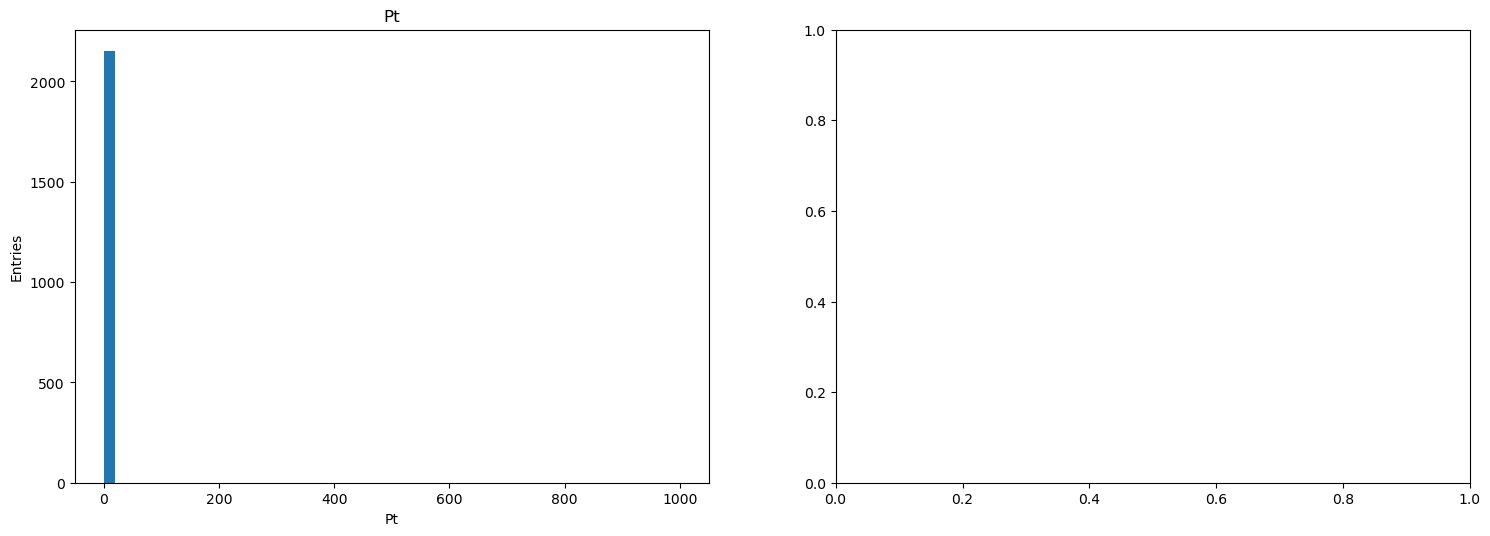

In [57]:
bin_number = 50
low_range = 0
high_range = 1000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.hist(mu_truth_had_tau_vis_p4.pt / 1000., bins=bin_number, range=(low_range, high_range))
ax1.set_xlabel('Pt')
ax1.set_ylabel('Entries')
ax1.set_title('Pt')
ax2.hist(mu_matched_truth_taus.pt / 1000., bins=bin_number, range=(low_range, high_range))
ax2.set_xlabel('Pt')
ax2.set_title('Pt (Matched)')
fig.suptitle('Tau Pt', size=20)
plt.show()

plot_x, plot_y = eff_hist_lists(mu_matched_truth_taus.pt / 1000., mu_truth_had_tau_vis_p4.pt / 1000., low_range, high_range, bin_number)

plt.plot(plot_x, plot_y, drawstyle='steps')
plt.ylim(0, 1.2)
plt.xlim(low_range, high_range)
plt.xlabel('Tau True Visible Pt')
plt.ylabel('Efficiency')
plt.title('Tau Truth-Match Efficiency vs. True Visible Pt')
plt.show()

### True Visible dR

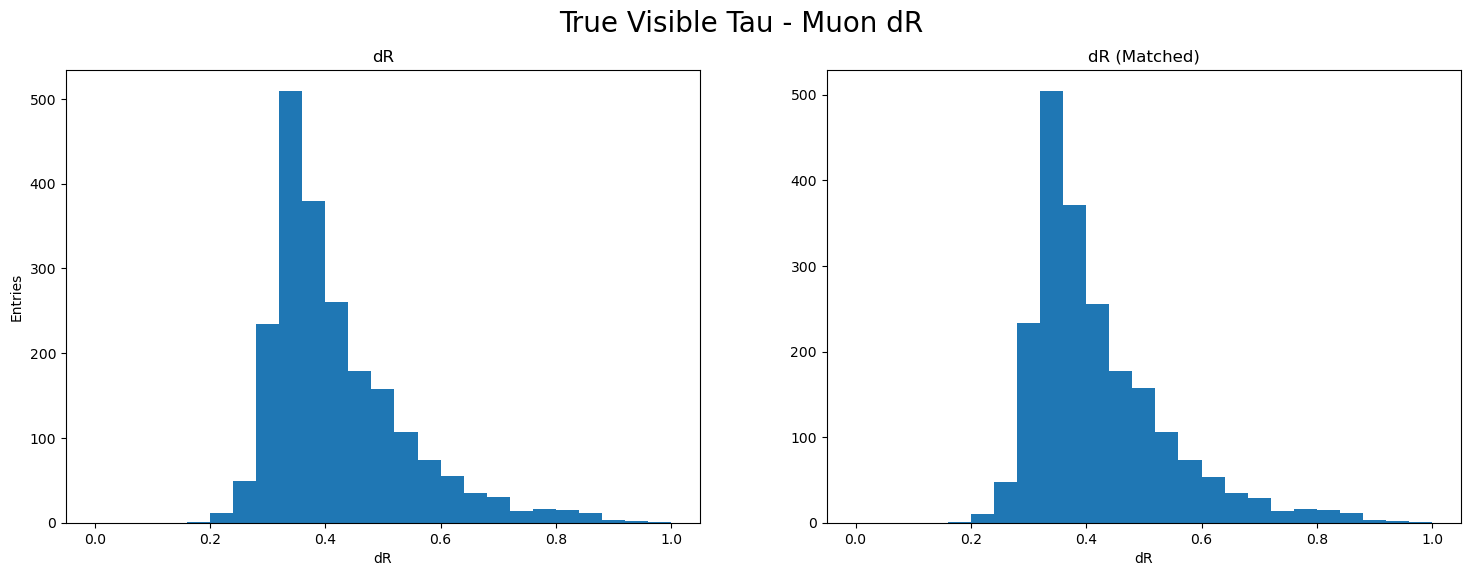

/eos/home-i00/n/nicholas/SWAN_projects/DiTauReco/scripts/bbtautau_helpers.py:304: RuntimeWarning: invalid value encountered in true_divide
  eff_hist = np.divide(num_hist, denom_hist)


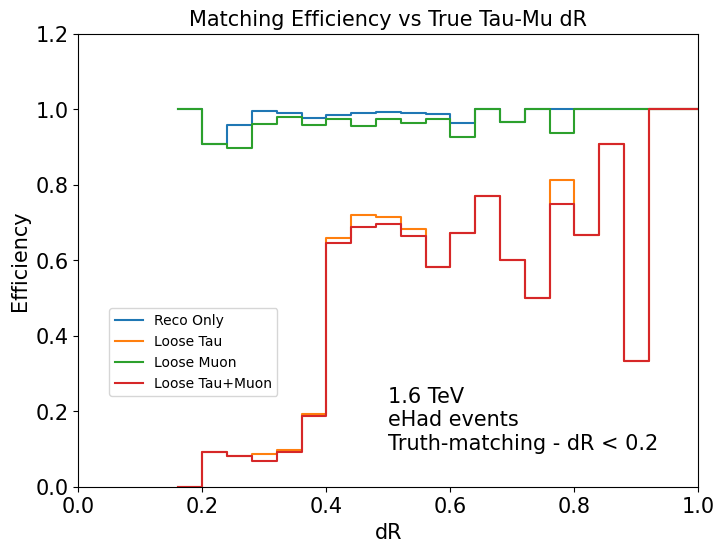

In [66]:
bin_number = 25
low_range = 0
high_range = 1

matched_truth_vis_drs = truth_vis_dr[both_matched_mask]
loose_tau_matched_truth_vis_drs = truth_vis_dr[both_matched_loose_tau_mask]
loose_mu_matched_truth_vis_drs = truth_vis_dr[both_matched_loose_mu_mask]
loose_both_matched_truth_vis_drs = truth_vis_dr[both_matched_both_loose_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.hist(truth_vis_dr, bins=bin_number, range=(low_range, high_range))
ax1.set_xlabel('dR')
ax1.set_ylabel('Entries')
ax1.set_title('dR')
ax2.hist(matched_truth_vis_drs, bins=bin_number, range=(low_range, high_range))
ax2.set_xlabel('dR')
ax2.set_title('dR (Matched)')
fig.suptitle('True Visible Tau - Muon dR', size=20)
plt.show()

reco_plot_x, reco_plot_y = eff_hist_lists(matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)
loose_tau_plot_x, loose_tau_plot_y = eff_hist_lists(loose_tau_matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)
loose_mu_plot_x, loose_mu_plot_y = eff_hist_lists(loose_mu_matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)
loose_both_plot_x, loose_both_plot_y = eff_hist_lists(loose_both_matched_truth_vis_drs, truth_vis_dr, low_range, high_range, bin_number)

plt.figure(figsize=(8,6))
plt.plot(reco_plot_x, reco_plot_y, drawstyle='steps', label='Reco Only')
plt.ylim(0, 1.2)
plt.xlim(low_range, high_range)
plt.xlabel('dR', size=15)
plt.xticks(size=15)
plt.ylabel('Efficiency', size=15)
plt.yticks(size=15)
plt.title('Matching Efficiency vs True Tau-Mu dR', size=15)
plt.plot(loose_tau_plot_x, loose_tau_plot_y, drawstyle='steps', label='Loose Tau')
plt.plot(loose_mu_plot_x, loose_mu_plot_y, drawstyle='steps', label='Loose Muon')
plt.plot(loose_both_plot_x, loose_both_plot_y, drawstyle='steps', label='Loose Tau+Muon')
plt.text(0.5, 0.1, '1.6 TeV\neHad events\nTruth-matching - dR < 0.2', size=15)
plt.legend(loc=[0.05, 0.2])
plt.show()

# DiTau Efficiency

### True Higgs Pt

In [ ]:
bin_number = 50
low_range = 0
high_range = 2000

mu_matched_truth_higgs_p4 = mu_truth_higgs_p4[tm_hadmu_event_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.hist(mu_truth_higgs_p4.pt / 1000., bins=bin_number, range=(low_range, high_range))
ax1.set_xlabel('Pt')
ax1.set_ylabel('Entries')
ax1.set_title('Pt')
ax2.hist(mu_matched_truth_higgs_p4.pt / 1000., bins=bin_number, range=(low_range, high_range))
ax2.set_xlabel('Pt')
ax2.set_title('Pt (Matched)')
fig.suptitle('True Higgs Pt', size=20)
plt.show()

plot_x, plot_y = eff_hist_lists(mu_matched_truth_higgs_p4.pt / 1000., mu_truth_higgs_p4.pt / 1000., low_range, high_range, bin_number)

plt.plot(plot_x, plot_y, drawstyle='steps')
plt.ylim(0, 1.2)
plt.xlim(low_range, high_range)
plt.xlabel('Pt')
plt.ylabel('Efficiency')
plt.title('True Higgs Pt')
plt.show()

### True Visible dR

In [ ]:
bin_number = 50
low_range = 0
high_range = 1

mu_matched_truth_vis_drs = mu_truth_vis_dr[tm_hadmu_event_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.hist(mu_truth_vis_dr, bins=bin_number, range=(low_range, high_range))
ax1.set_xlabel('dR')
ax1.set_ylabel('Entries')
ax1.set_title('dR')
ax2.hist(mu_matched_truth_vis_drs, bins=bin_number, range=(low_range, high_range))
ax2.set_xlabel('dR')
ax2.set_title('dR (Matched)')
fig.suptitle('True Visible Tau - Muon dR', size=20)
plt.show()

plot_x, plot_y = eff_hist_lists(mu_matched_truth_vis_drs, mu_truth_vis_dr, low_range, high_range, bin_number)

plt.plot(plot_x, plot_y, drawstyle='steps')
plt.ylim(0, 1.2)
plt.xlim(low_range, high_range)
plt.xlabel('dR')
plt.ylabel('Efficiency')
plt.title('True Visible Tau - Muon dR')
plt.show()